### MaxCut

##### CQM

In [2]:
from QHyper.problems.max_cut import MaxCut, MaxCutProblem


max_cut = MaxCut()
max_cut.create_sample_graph()

max_cut_problem = MaxCutProblem(max_cut)
max_cut_problem.objective_function


2*x0*x1 + 2*x0*x2 - 2*x0 + 2*x1*x3 - 2*x1 + 2*x2*x3 + 2*x2*x4 - 3*x2 + 2*x3*x4 - 3*x3 - 2*x4

In [ ]:
from QHyper.solvers.cqm import CQM


max_cut_cqm = CQM(max_cut_problem, 5)
max_cut_samples = max_cut_cqm.solve()

In [ ]:
max_cut_samples

In [ ]:
import networkx as nx

import matplotlib
# matplotlib.use("agg")
from matplotlib import pyplot as plt

plt.cla()

G = max_cut_problem.max_cut_graph
S0 = [i+1 for i, val in enumerate(max_cut_samples.values()) if val == 0]
S1 = [i+1 for i, val in enumerate(max_cut_samples.values()) if val == 1]
lut = {i+1: val for i, val in enumerate(max_cut_samples.values())}
print(lut)
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)


filename = "./demo_output/maxcut_cqm_plot.png"
plt.savefig(filename, bbox_inches='tight')
print("\nYour plot is saved to {}".format(filename))
plt.show()

##### DQM

In [1]:
from QHyper.problems.max_cut import MaxCut, MaxCutProblem


max_cut = MaxCut()
max_cut.create_sample_graph()

max_cut_problem = MaxCutProblem(max_cut)
max_cut_problem.objective_function

2*x0*x1 + 2*x0*x2 - 2*x0 + 2*x1*x3 - 2*x1 + 2*x2*x3 + 2*x2*x4 - 3*x2 + 2*x3*x4 - 3*x3 - 2*x4

In [4]:
from QHyper.solvers.dqm import DQM


max_cut_dqm = DQM(max_cut_problem, 5)
max_cut_sampleset = max_cut_dqm.solve()

In [5]:
res = max_cut_sampleset.first.sample

In [6]:
res

{'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}

{1: 1, 2: 0, 3: 0, 4: 1, 5: 1}

Your plot is saved to ./demo_output/maxcut_dqm_plot.png


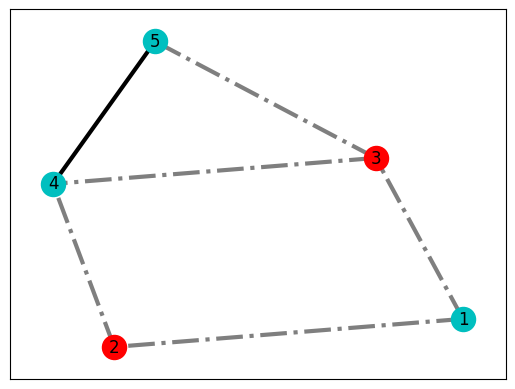

In [7]:
import networkx as nx

import matplotlib
# matplotlib.use("agg")
from matplotlib import pyplot as plt

plt.cla()

G = max_cut_problem.max_cut_graph
S0 = [i+1 for i, val in enumerate(res.values()) if val == 0]
S1 = [i+1 for i, val in enumerate(res.values()) if val == 1]
lut = {i+1: val for i, val in enumerate(res.values())}
print(lut)
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)


filename = "./demo_output/maxcut_dqm_plot.png"
plt.savefig(filename, bbox_inches='tight')
print("\nYour plot is saved to {}".format(filename))
plt.show()

##### QUBO experiments

In [ ]:
from QHyper.solvers.converter import Converter


cut_qubo = Converter.to_qubo(max_cut_problem)

In [ ]:
cut_qubo

In [ ]:
import dimod


binary_polynomial = dimod.BinaryPolynomial(max_cut_problem.objective_function.as_dict(), dimod.BINARY)

In [ ]:
binary_polynomial

#### Brain Community Detection

##### DQM

In [1]:
from QHyper.problems.brain_community_detection import BrainCommunityDetection


num_cases = 4
path = "../QHyper/problems/brain_community_data"
data_name = 'Edge_AAL90_Binary'
brain = BrainCommunityDetection(path, data_name, num_cases)
brain.objective_function



<class 'networkx.utils.decorators.argmap'> compilation 9:5: FutureWarning: modularity_matrix will return a numpy array instead of a matrix in NetworkX 3.0.


[]

In [ ]:
import sympy


G = brain.G

variables = sympy.symbols(' '.join([f'x{i}' for i in range(len(G.nodes))]))

In [ ]:
from sympy.core.expr import Expr
from typing import cast
from QHyper.hyperparameter_gen.parser import Expression


equation: Expr = cast(Expr, 0)
cross_out = [[0 for _ in range(len(G.nodes))] for _ in range(len(G.nodes))]
for i in G.nodes():
    for j in G.nodes():
        if i==j:
            continue
        if cross_out[i][j] != 0:
            continue
        u_var, v_var = variables[i], variables[j]
        print(u_var, v_var, i, j)
        equation += u_var*v_var*brain.B[i,j]
        cross_out[i][j] = 1
print("done")
equation *= -1
print("done")

# brain.objective_function = Expression(equation)

In [ ]:
equation_expression = Expression(equation)

In [ ]:
brain.objective_function = equation_expression

In [ ]:
from QHyper.solvers.dqm import DQM


brain_dqm = DQM(brain, 5)
# brain_sampleset = brain_dqm.solve()

In [ ]:
equation_expression.as_dict()


In [ ]:
brain_sampleset = brain_dqm.solve()

In [ ]:
brain_sampleset.first.sample

In [ ]:
import numpy as np


samples = brain_sampleset
sample = samples.first.sample
energy = samples.first.energy
run_time=(samples.info['run_time'])*0.001

communities=[]
for k in (range(brain.num_cases)):
    comm=[]
    for i in sample:
        if sample[i]==k:
            comm.append(i)
    communities.append(set(comm))

counts = np.zeros(brain.num_cases)
for s in sample.values():
    counts[s] += 1

print(sample)

In [ ]:
output_folder = "./demo_output"
results = communities, run_time, energy, counts, sample
brain.plot_results(output_folder, results)